# Práctica 3: Aprendizaje por Refuerzo

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Creación del entorno

In [2]:
render_mode = "rgb_array"

env = gym.make("Pendulum-v1", render_mode=render_mode)
obs, info = env.reset()

In [3]:
def muestra_entorno(env:gym.Env):
    if render_mode == "rgb_array":
        plt.imshow(env.render())
        plt.show()

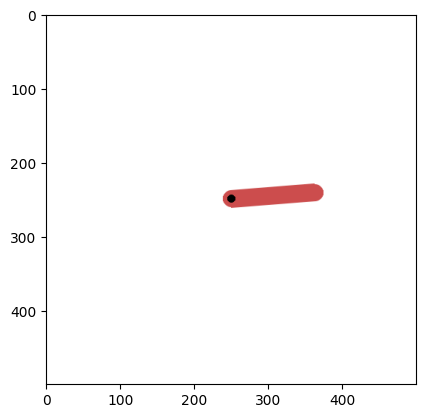

In [4]:
muestra_entorno(env)

## Discretización de estados y acciones

In [5]:
NUM_INTERVALOS_ANGULOS = 20
NUM_INTERVALOS_VELOCIDAD = 16
NUM_ACCIONES = 15

In [6]:
# theta
minim, maxim = -np.pi, np.pi
interval = (maxim-minim)/NUM_INTERVALOS_ANGULOS
angulos = np.arange(minim, maxim, interval)

# vel
minim, maxim = -8, 8
interval = (maxim-minim)/NUM_INTERVALOS_VELOCIDAD
velocidades = np.arange(minim, maxim, interval)

# torque
# modificamos ligeramente la lógica para tener la acción 0 (no aplicar fuerza)
minim, maxim = -2, 2
interval = (maxim-minim)/(NUM_ACCIONES-1)
acciones = np.arange(minim, maxim+interval, interval)

print(f"Los {angulos.shape} intervalos para discretizar los estados de los ángulos son: {angulos}")
print(f"Los {velocidades.shape} intervalos para discretizar los estados de las velocidades son: {velocidades}")
print(f"Las {acciones.shape} acciones válidas son: {acciones}")

Los (20,) intervalos para discretizar los estados de los ángulos son: [-3.14159265 -2.82743339 -2.51327412 -2.19911486 -1.88495559 -1.57079633
 -1.25663706 -0.9424778  -0.62831853 -0.31415927  0.          0.31415927
  0.62831853  0.9424778   1.25663706  1.57079633  1.88495559  2.19911486
  2.51327412  2.82743339]
Los (16,) intervalos para discretizar los estados de las velocidades son: [-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.]
Las (15,) acciones válidas son: [-2.00000000e+00 -1.71428571e+00 -1.42857143e+00 -1.14285714e+00
 -8.57142857e-01 -5.71428571e-01 -2.85714286e-01 -8.88178420e-16
  2.85714286e-01  5.71428571e-01  8.57142857e-01  1.14285714e+00
  1.42857143e+00  1.71428571e+00  2.00000000e+00]


### Funciones auxiliares

In [7]:
def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

In [8]:
from collections import namedtuple

Estado = namedtuple('Estado', ['theta', 'vel'])

def get_estado(env:gym.Env) -> Estado:
    state = env.get_wrapper_attr("state")
    theta, vel = state[0], state[1]
    theta = angle_normalize(theta)
        
    # por alguna razón, los índices de digitize empiezan en 1,
    # entonces hay que compensar
    theta = np.digitize(theta, angulos) - 1
    vel = np.digitize(vel, velocidades) - 1
        
    return Estado(theta, vel)

def set_estado(env:gym.Env, estado):
    env.set_wrapper_attr("state", estado)

El estado interno es [-1.49423543 -0.24102369]
Nuestro estado es Estado(theta=5, vel=7)


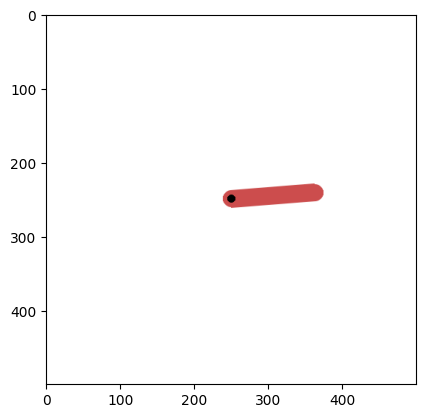

In [9]:
print("El estado interno es", env.get_wrapper_attr("state"))
print("Nuestro estado es", get_estado(env))
muestra_entorno(env)

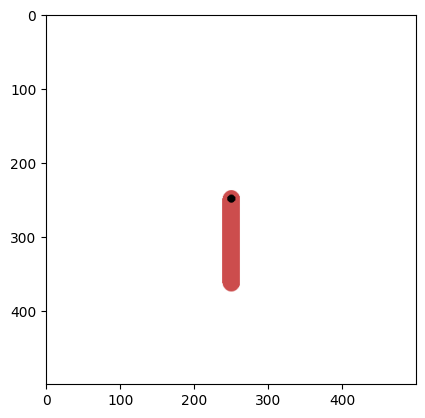

El estado interno es [3.141592653589793, 0.0]
Nuestro estado es Estado(theta=0, vel=8)


In [10]:
abajo = [np.pi, 0.]
set_estado(env, abajo)
muestra_entorno(env)
print("El estado interno es", env.get_wrapper_attr("state"))
print("Nuestro estado es", get_estado(env))

In [11]:
def get_accion_epsilon_greedy(q_valores:np.ndarray, epsilon:float=0):
    if np.random.random() < epsilon:
        return np.random.randint(0, NUM_ACCIONES)
    return np.argmax(q_valores)

## Algoritmos

In [12]:
def moving_average(a, n):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_retornos(retornos, nombre, rango=100):
    retornos = np.array(retornos)
    media_movil_x = np.arange(rango-1, len(retornos))
    media_movil_y = moving_average(retornos, rango)

    plt.plot(retornos, "b", label="Retorno por episodio")
    plt.plot(media_movil_x, media_movil_y, "r", label="Media móvil de 100 episodios")
    plt.title(f"Evolución durante el aprendizaje ({nombre})")
    plt.xlabel("Episodios")
    plt.ylabel("Recompensa")
    plt.legend(loc="lower right")
    plt.show()
    
    return media_movil_y

### Montecarlo

#### Implementación

In [13]:
import time

def get_perturbacion(A):
    if np.random.random() < 0.05:
        # la primera acción es -2 y la última es 2
        A = np.random.choice([0, NUM_ACCIONES-1])
    return A


def sample_policy(estado: Estado, politica: np.ndarray) -> int:
    probs = politica[estado.theta, estado.vel]
    accion = np.random.choice(np.arange(len(probs)), p=probs)
    return accion


def simula_episodio(politica: np.ndarray, perturbaciones=False):
    env.reset()
    estado = get_estado(env)
    
    start = time.time()
    completado = False
    retorno = 0
    num_pasos = 0
    recorrido = []
    while not completado:
        if time.time() - start > 10:
            completado = True
            continue
        
        accion_idx = sample_policy(estado, politica)
        
        if perturbaciones:
            get_perturbacion(accion_idx)
        
        accion_tomada = np.array([acciones[accion_idx]])
        
        _, recompensa, terminado, truncado, _ = env.step(accion_tomada)
        completado = terminado or truncado

        recorrido.append((estado, accion_idx, recompensa))

        retorno += recompensa
        num_pasos += 1

        estado = get_estado(env)
    
    return (retorno, num_pasos, recorrido)

def crea_politica_avara(q_values: np.ndarray) -> np.ndarray:
    politica = np.zeros_like(q_values)

    for theta in range(q_values.shape[0]):
        for vel in range(q_values.shape[1]):
            acciones = q_values[theta, vel]
            mejor_accion = np.argmax(acciones)
            politica[theta, vel, mejor_accion] = 1.0
    
    return politica


In [14]:
def mc_control(num_episodios: int = 500, GAMMA: float = 0.9, epsilon: float = 0.2, perturbaciones=False) -> np.ndarray:
    q_valores = np.zeros((NUM_INTERVALOS_ANGULOS, NUM_INTERVALOS_VELOCIDAD, NUM_ACCIONES))
    politica = np.ones_like(q_valores) * (1.0 / NUM_ACCIONES) # política inicial aleatoria (ε-soft)
    
    # Inicializamos el acumulador de retornos
    retornos = [[[[] for _ in range(NUM_ACCIONES)] for _ in range(NUM_INTERVALOS_VELOCIDAD)] for _ in range(NUM_INTERVALOS_ANGULOS)]
    ret_por_episodios = []

    for i in range(num_episodios):
        start_time = time.time()
        # Simulamos un episodio con la política actual
        env.reset()
        R, num_pasos, recorrido = simula_episodio(politica, perturbaciones=perturbaciones)
        ret_por_episodios.append(R)

        g = 0
        # pares_restantes = [(estado, accion_tomada) for estado, accion_tomada, _ in recorrido]  # para First-visit

        T = len(recorrido) - 1
        for t in range(T-1, -1, -1):
            estado_t, accion_t, _ = recorrido[t] # (st, act, r)
            _, _, r_t_mas_1 = recorrido[t+1]
            
            g = GAMMA * g + r_t_mas_1
            
            if not (estado_t, accion_t) in [(recorrido[i][0], recorrido[i][1]) for i in range(0, t)]:
                theta = estado_t.theta
                vel = estado_t.vel
                accion_t = int(accion_t)

                # Guardamos el retorno para este par (s,a)
                retornos[theta][vel][accion_t].append(g)

                # Estimamos q(s,a) como la media de los retornos
                q_valores[theta, vel, accion_t] = np.mean(retornos[theta][vel][accion_t])

                # --- Mejora de política ε-greedy en ese estado ---
                # Obtenemos la mejor acción (greedy)
                
                q_valores_actuales = q_valores[theta, vel]
                mejor_accion = np.argmax(np.random.random(q_valores_actuales.shape) * (q_valores_actuales==q_valores_actuales.max()))
                
                for a in range(NUM_ACCIONES):
                    if a == mejor_accion:
                        politica[theta, vel, a] = 1 - epsilon + (epsilon / NUM_ACCIONES)
                    else:
                        politica[theta, vel, a] = epsilon / NUM_ACCIONES

        if i % 100 == 0 and i > 0:
            print(f"Episodio {i} | Retorno: {R:.3f} | Pasos: {num_pasos} | avg R en los últimos 100 eps.: {np.mean(ret_por_episodios[-100:]):.3f}")


    return q_valores, crea_politica_avara(politica), ret_por_episodios

#### Aprendizaje

In [15]:
GAMMA_montecarlo = 0.99
EPSILON_montecarlo = 0.1
episodios_montecarlo = 20000

In [16]:
q_valores_montecarlo, politica_montecarlo, retornos_montecarlo = mc_control(num_episodios=episodios_montecarlo,
                                                                            GAMMA=GAMMA_montecarlo,
                                                                            epsilon=EPSILON_montecarlo)

Episodio 100 | Retorno: -366.270 | Pasos: 200 | avg R en los últimos 100 eps.: -1158.936
Episodio 200 | Retorno: -253.842 | Pasos: 200 | avg R en los últimos 100 eps.: -647.812
Episodio 300 | Retorno: -509.078 | Pasos: 200 | avg R en los últimos 100 eps.: -422.012
Episodio 400 | Retorno: -851.550 | Pasos: 200 | avg R en los últimos 100 eps.: -459.930
Episodio 500 | Retorno: -376.024 | Pasos: 200 | avg R en los últimos 100 eps.: -449.245
Episodio 600 | Retorno: -723.237 | Pasos: 200 | avg R en los últimos 100 eps.: -424.212
Episodio 700 | Retorno: -366.546 | Pasos: 200 | avg R en los últimos 100 eps.: -397.758
Episodio 800 | Retorno: -717.139 | Pasos: 200 | avg R en los últimos 100 eps.: -378.045
Episodio 900 | Retorno: -465.540 | Pasos: 200 | avg R en los últimos 100 eps.: -373.026
Episodio 1000 | Retorno: -490.065 | Pasos: 200 | avg R en los últimos 100 eps.: -425.426
Episodio 1100 | Retorno: -765.310 | Pasos: 200 | avg R en los últimos 100 eps.: -417.498
Episodio 1200 | Retorno: -793

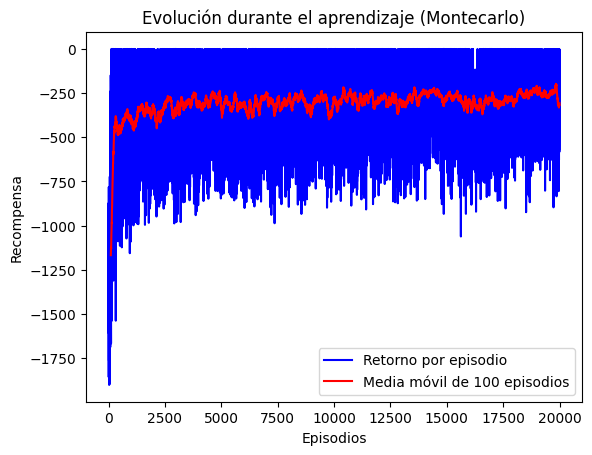

In [17]:
rango_medias = 100
medias_montecarlo = plot_retornos(retornos_montecarlo, "Montecarlo", rango_medias)

### SARSA y Q-Learning

In [18]:
def SARSA_o_QLRN(mode, num_episodios:int = 500, ALPHA:float = 0.1, GAMMA:float = 0.9, EPSILON:float = 0.25, animate = False, perturbaciones=False) -> np.ndarray:
    q_valores = np.zeros((NUM_INTERVALOS_ANGULOS, NUM_INTERVALOS_VELOCIDAD, NUM_ACCIONES))

    retornos = []

    for i in range(num_episodios):
        env.reset()

        if animate:
            muestra_entorno(env)
        
        start_time = time.time()
        
        S = get_estado(env)
        A = get_accion_epsilon_greedy(q_valores[S.theta, S.vel], epsilon=EPSILON)
        
        if perturbaciones:
            A = get_perturbacion(A)
        
        completado = False
        retorno = 0
        num_pasos = 0

        while not completado:
            if time.time() - start_time > 10:                
                completado = True
                continue
            
            num_pasos += 1
                        
            A = np.array([A])
            
            torque = acciones[A]
            
            _, R, terminado, truncado, _ = env.step(torque)
            completado = terminado or truncado

                        
            S_ = get_estado(env)

            retorno += R

            A_ = get_accion_epsilon_greedy(q_valores[S_.theta, S_.vel], epsilon=EPSILON)

            actual = q_valores[S.theta, S.vel, A]
            
            
            if mode == "sarsa":
                q_valores[S.theta, S.vel, A] = actual + ALPHA * (R + GAMMA * q_valores[S_.theta, S_.vel, A_] - actual)
            elif mode == "q_learning":
                q_valores[S.theta, S.vel, A] = actual + ALPHA * (R + GAMMA * np.max(q_valores[S_.theta, S_.vel]) - actual)

            S = S_
            A = A_
            
            
        retornos.append(retorno)
        if i % 100 == 0 and i > 0:
            print(f"Episodio {i} | Retorno: {retorno:.3f} | Pasos: {num_pasos} | avg R en los últimos 100 eps.: {np.mean(retornos[-100:]):.3f}")
        
    return q_valores, retornos


#### SARSA

In [19]:
GAMMA_sarsa = 0.99
ALPHA_sarsa = 0.15
EPSILON_sarsa = 0.15
episodios_sarsa = 20000

In [20]:
q_valores_sarsa, retornos_sarsa = SARSA_o_QLRN(mode="sarsa",
                                               num_episodios=episodios_sarsa,
                                               ALPHA=ALPHA_sarsa,
                                               GAMMA=GAMMA_sarsa,
                                               EPSILON=EPSILON_sarsa,
                                               animate=False)

Episodio 100 | Retorno: -965.068 | Pasos: 200 | avg R en los últimos 100 eps.: -1235.333
Episodio 200 | Retorno: -1375.702 | Pasos: 200 | avg R en los últimos 100 eps.: -1178.850
Episodio 300 | Retorno: -1381.173 | Pasos: 200 | avg R en los últimos 100 eps.: -1189.821
Episodio 400 | Retorno: -1273.540 | Pasos: 200 | avg R en los últimos 100 eps.: -1183.205
Episodio 500 | Retorno: -1490.723 | Pasos: 200 | avg R en los últimos 100 eps.: -1164.127
Episodio 600 | Retorno: -821.577 | Pasos: 200 | avg R en los últimos 100 eps.: -1135.896
Episodio 700 | Retorno: -1412.072 | Pasos: 200 | avg R en los últimos 100 eps.: -1095.686
Episodio 800 | Retorno: -1072.231 | Pasos: 200 | avg R en los últimos 100 eps.: -1073.745
Episodio 900 | Retorno: -1483.227 | Pasos: 200 | avg R en los últimos 100 eps.: -1086.722
Episodio 1000 | Retorno: -1197.217 | Pasos: 200 | avg R en los últimos 100 eps.: -1040.393
Episodio 1100 | Retorno: -1485.206 | Pasos: 200 | avg R en los últimos 100 eps.: -1059.146
Episodio 1

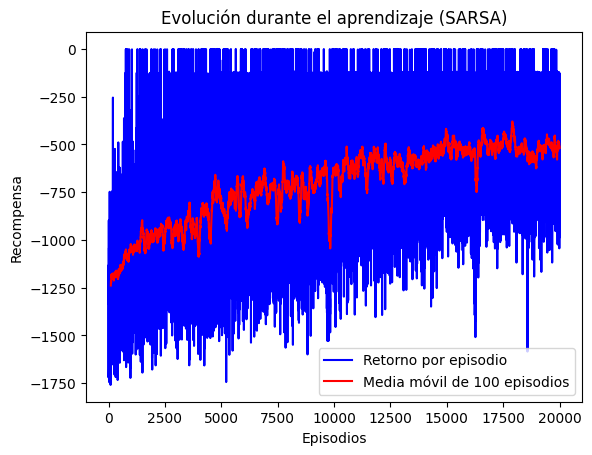

In [21]:
medias_sarsa = plot_retornos(retornos_sarsa, "SARSA", rango_medias)

#### Q-Learning

In [22]:
GAMMA_q_learning = 0.99
ALPHA_q_learning = 0.1
EPSILON_q_learning = 0.1
episodios_q_learning = 20000

In [23]:
q_valores_q_learning, retornos_q_learning = SARSA_o_QLRN(mode="q_learning",
                                                         num_episodios=episodios_q_learning,
                                                         ALPHA=ALPHA_q_learning,
                                                         GAMMA=GAMMA_q_learning,
                                                         EPSILON=EPSILON_q_learning,
                                                         animate=False)

Episodio 100 | Retorno: -1077.701 | Pasos: 200 | avg R en los últimos 100 eps.: -1243.384
Episodio 200 | Retorno: -896.875 | Pasos: 200 | avg R en los últimos 100 eps.: -1143.801
Episodio 300 | Retorno: -1171.960 | Pasos: 200 | avg R en los últimos 100 eps.: -1185.416
Episodio 400 | Retorno: -1337.275 | Pasos: 200 | avg R en los últimos 100 eps.: -1148.756
Episodio 500 | Retorno: -858.423 | Pasos: 200 | avg R en los últimos 100 eps.: -1165.129
Episodio 600 | Retorno: -1208.673 | Pasos: 200 | avg R en los últimos 100 eps.: -1156.606
Episodio 700 | Retorno: -1189.932 | Pasos: 200 | avg R en los últimos 100 eps.: -1164.347
Episodio 800 | Retorno: -1365.949 | Pasos: 200 | avg R en los últimos 100 eps.: -1104.263
Episodio 900 | Retorno: -1554.861 | Pasos: 200 | avg R en los últimos 100 eps.: -1084.784
Episodio 1000 | Retorno: -969.268 | Pasos: 200 | avg R en los últimos 100 eps.: -1082.029
Episodio 1100 | Retorno: -743.188 | Pasos: 200 | avg R en los últimos 100 eps.: -1044.780
Episodio 120

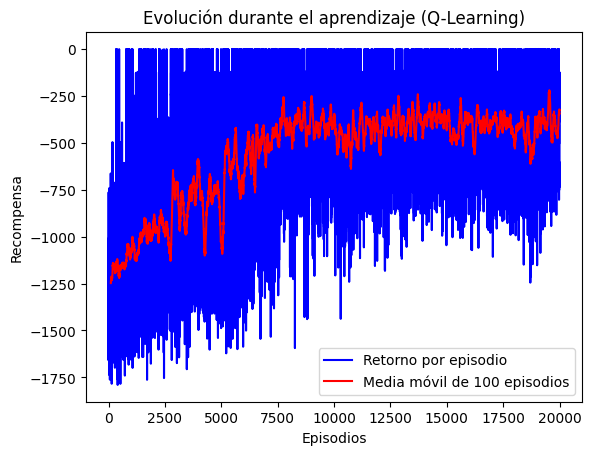

In [24]:
medias_q_learning = plot_retornos(retornos_q_learning, "Q-Learning", rango_medias)

## Evaluación

In [25]:
import random
min_theta, max_theta = -np.pi, np.pi
min_vel, max_vel = -1, 1

def genera_array_estados_aleatorios(n: int):
    array = list()
    for i in range(n):
        array.append(np.array([random.uniform(min_theta, max_theta), random.uniform(min_vel, max_vel)]))
    return array

In [26]:
def run_one_episode(politica, env, initial_state=None, perturbaciones=False):
        env.reset()
        if initial_state is not None:
            set_estado(env, initial_state)
        
        total_R = 0
        completado = False
        while not completado:
            S = get_estado(env)
            A = get_accion_epsilon_greedy(politica[S.theta, S.vel], epsilon=0)
            if perturbaciones:
                A = get_perturbacion(A)

            A = np.array([A])
            
            _, R, terminado, truncado, _ = env.step(acciones[A])
            completado = terminado or truncado
            total_R += R
        
        return total_R

def evaluate_method(politica, env, estados_iniciales, perturbaciones=False):
    print(f"En {len(estados_iniciales)} episodios:")
    
    retornos = []
    for estado_inicial in estados_iniciales:
        retornos.append(run_one_episode(politica, env, initial_state=estado_inicial, perturbaciones=perturbaciones))

    media_greedy = np.mean(retornos)
    std_greedy = np.std(retornos)
    print(f"Este método consigue una recompensa media de {media_greedy:.3f} con una política puramente greedy")
    print()
    
    return round(media_greedy, 2), round(std_greedy, 2)
    

### Creación de políticas deterministas

In [27]:
# la de Montecarlo ya la tenemos
politica_sarsa = crea_politica_avara(q_valores_sarsa)
politica_q_learning = crea_politica_avara(q_valores_q_learning)

### Promedio durante varios episodios

In [28]:
env2 = gym.make("Pendulum-v1", render_mode="rgb_array")
_, _ = env2.reset()

In [29]:
episodios_test = 1000

iniciales = genera_array_estados_aleatorios(episodios_test)

#### Sin perturbaciones

In [30]:
print(f"Montecarlo (aprendizaje durante {episodios_montecarlo} episodios, gamma={GAMMA_montecarlo}, epsilon={EPSILON_montecarlo})")
r_media_mc, std_mc = evaluate_method(politica_montecarlo, env2, estados_iniciales=iniciales)

print(f"SARSA (aprendizaje durante {episodios_sarsa} episodios, alpha={ALPHA_sarsa}, gamma={GAMMA_sarsa}, epsilon={EPSILON_sarsa})")
r_media_sarsa, std_sarsa = evaluate_method(politica_sarsa, env2, estados_iniciales=iniciales)

print(f"Q-Learning (aprendizaje durante {episodios_q_learning} episodios, alpha={ALPHA_q_learning}, gamma={GAMMA_q_learning}, epsilon={EPSILON_q_learning})")
r_media_q_learning, std_q_learning = evaluate_method(politica_q_learning, env2, estados_iniciales=iniciales)

Montecarlo (aprendizaje durante 20000 episodios, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -219.010 con una política puramente greedy

SARSA (aprendizaje durante 20000 episodios, alpha=0.15, gamma=0.99, epsilon=0.15)
En 1000 episodios:
Este método consigue una recompensa media de -215.355 con una política puramente greedy

Q-Learning (aprendizaje durante 20000 episodios, alpha=0.1, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -187.293 con una política puramente greedy



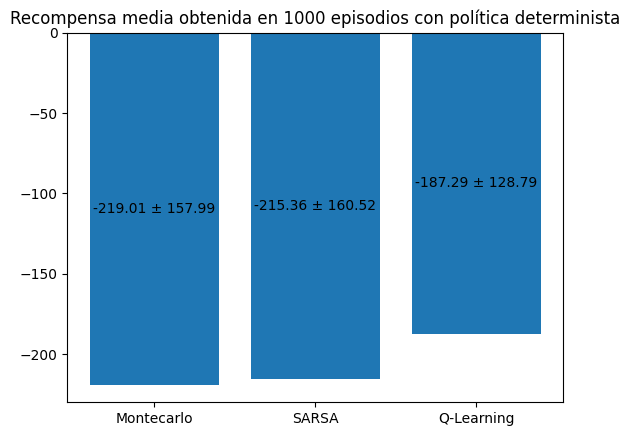

In [31]:
bar = plt.bar(["Montecarlo",
                "SARSA",
                "Q-Learning"],
                [r_media_mc, r_media_sarsa, r_media_q_learning])

labels = [f"{r_media_mc} ± {std_mc}",
          f"{r_media_sarsa} ± {std_sarsa}",
          f"{r_media_q_learning} ± {std_q_learning}"]

plt.bar_label(bar, labels, label_type="center")
plt.title(f"Recompensa media obtenida en {episodios_test} episodios con política determinista")
plt.show()

#### Con perturbaciones

In [44]:
print(f"Montecarlo (aprendizaje durante {episodios_montecarlo} episodios, gamma={GAMMA_montecarlo}, epsilon={EPSILON_montecarlo})")
r_media_mc, std_mc = evaluate_method(politica_montecarlo, env2, estados_iniciales=iniciales, perturbaciones=True)

print(f"SARSA (aprendizaje durante {episodios_sarsa} episodios, alpha={ALPHA_sarsa}, gamma={GAMMA_sarsa}, epsilon={EPSILON_sarsa})")
r_media_sarsa, std_sarsa = evaluate_method(politica_sarsa, env2, estados_iniciales=iniciales, perturbaciones=True)

print(f"Q-Learning (aprendizaje durante {episodios_q_learning} episodios, alpha={ALPHA_q_learning}, gamma={GAMMA_q_learning}, epsilon={EPSILON_q_learning})")
r_media_q_learning, std_q_learning = evaluate_method(politica_q_learning, env2, estados_iniciales=iniciales, perturbaciones=True)

Montecarlo (aprendizaje durante 20000 episodios, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -237.208 con una política puramente greedy

SARSA (aprendizaje durante 20000 episodios, alpha=0.15, gamma=0.99, epsilon=0.15)
En 1000 episodios:
Este método consigue una recompensa media de -249.001 con una política puramente greedy

Q-Learning (aprendizaje durante 20000 episodios, alpha=0.1, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -233.054 con una política puramente greedy



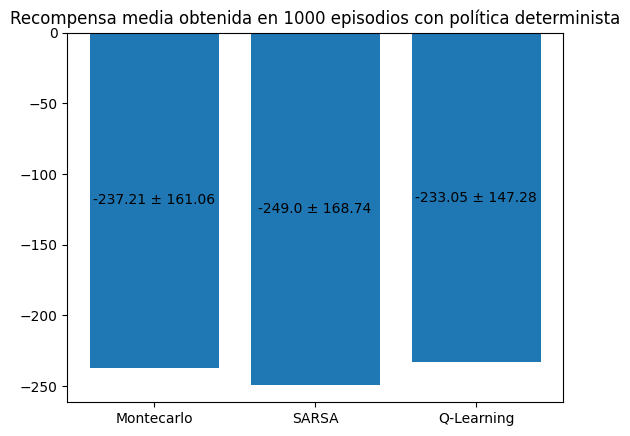

In [45]:
bar = plt.bar(["Montecarlo",
                "SARSA",
                "Q-Learning"],
                [r_media_mc, r_media_sarsa, r_media_q_learning])

labels = [f"{r_media_mc} ± {std_mc}",
          f"{r_media_sarsa} ± {std_sarsa}",
          f"{r_media_q_learning} ± {std_q_learning}"]

plt.bar_label(bar, labels, label_type="center")
plt.title(f"Recompensa media obtenida en {episodios_test} episodios con política determinista")
plt.show()

### Rendimiento como algoritmos de control

In [32]:
def plot_varios_retornos(medias, rango):
    eje_y = np.arange(rango, len(medias[0][0]) + rango)
    
    for media, name in medias:
        plt.plot(eje_y, media, label=name)
    
    plt.title(f"Evaluación como algoritmos de control")
    plt.xlabel("Episodios")
    plt.ylabel("Media móvil recompensa (100 eps.)")
    plt.legend(loc="lower right")
    plt.show()


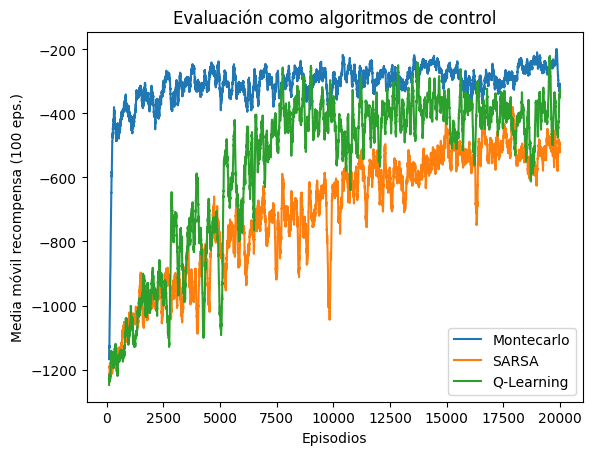

In [33]:
plot_varios_retornos([(medias_montecarlo, "Montecarlo"),
                      (medias_sarsa, "SARSA"),
                      (medias_q_learning, "Q-Learning")],
                        rango_medias)

## Prueba con renderizado

In [34]:
# env3 = gym.make("Pendulum-v1", render_mode="human")
# _, _ = env3.reset()

# run_one_episode(politica_montecarlo, env3)
# run_one_episode(politica_sarsa, env3)
# run_one_episode(politica_q_learning, env3)

## Perturbaciones

### Aprendizaje

Episodio 100 | Retorno: -1141.361 | Pasos: 200 | avg R en los últimos 100 eps.: -1187.643
Episodio 200 | Retorno: -125.101 | Pasos: 200 | avg R en los últimos 100 eps.: -799.924
Episodio 300 | Retorno: -251.772 | Pasos: 200 | avg R en los últimos 100 eps.: -557.350
Episodio 400 | Retorno: -377.416 | Pasos: 200 | avg R en los últimos 100 eps.: -552.953
Episodio 500 | Retorno: -620.156 | Pasos: 200 | avg R en los últimos 100 eps.: -518.745
Episodio 600 | Retorno: -877.414 | Pasos: 200 | avg R en los últimos 100 eps.: -495.649
Episodio 700 | Retorno: -244.001 | Pasos: 200 | avg R en los últimos 100 eps.: -438.078
Episodio 800 | Retorno: -371.539 | Pasos: 200 | avg R en los últimos 100 eps.: -387.024
Episodio 900 | Retorno: -611.132 | Pasos: 200 | avg R en los últimos 100 eps.: -417.183
Episodio 1000 | Retorno: -244.078 | Pasos: 200 | avg R en los últimos 100 eps.: -498.635
Episodio 1100 | Retorno: -645.756 | Pasos: 200 | avg R en los últimos 100 eps.: -404.243
Episodio 1200 | Retorno: -1.

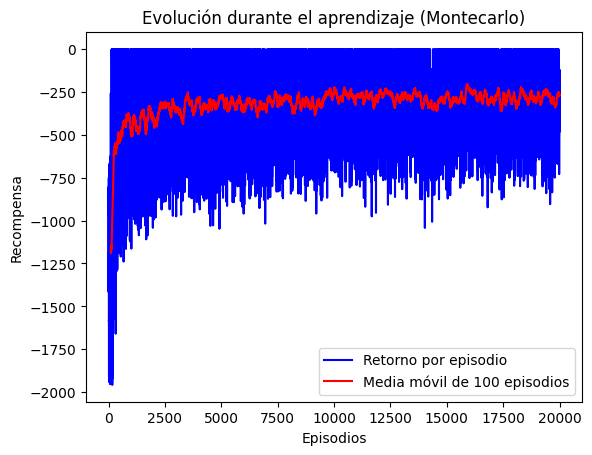

In [35]:
q_valores_montecarlo_p, politica_montecarlo_p, retornos_montecarlo_p = mc_control(num_episodios=episodios_montecarlo,
                                                                            GAMMA=GAMMA_montecarlo,
                                                                            epsilon=EPSILON_montecarlo,
                                                                            perturbaciones=True)

medias_montecarlo_p = plot_retornos(retornos_montecarlo_p, "Montecarlo", rango_medias)

Episodio 100 | Retorno: -1690.475 | Pasos: 200 | avg R en los últimos 100 eps.: -1234.309
Episodio 200 | Retorno: -859.303 | Pasos: 200 | avg R en los últimos 100 eps.: -1157.096
Episodio 300 | Retorno: -973.814 | Pasos: 200 | avg R en los últimos 100 eps.: -1215.302
Episodio 400 | Retorno: -1071.456 | Pasos: 200 | avg R en los últimos 100 eps.: -1139.180
Episodio 500 | Retorno: -1.241 | Pasos: 200 | avg R en los últimos 100 eps.: -1156.342
Episodio 600 | Retorno: -802.565 | Pasos: 200 | avg R en los últimos 100 eps.: -1128.733
Episodio 700 | Retorno: -1361.291 | Pasos: 200 | avg R en los últimos 100 eps.: -1135.628
Episodio 800 | Retorno: -1178.080 | Pasos: 200 | avg R en los últimos 100 eps.: -1082.565
Episodio 900 | Retorno: -1056.376 | Pasos: 200 | avg R en los últimos 100 eps.: -1048.834
Episodio 1000 | Retorno: -880.393 | Pasos: 200 | avg R en los últimos 100 eps.: -1035.130
Episodio 1100 | Retorno: -1185.232 | Pasos: 200 | avg R en los últimos 100 eps.: -1078.892
Episodio 1200 |

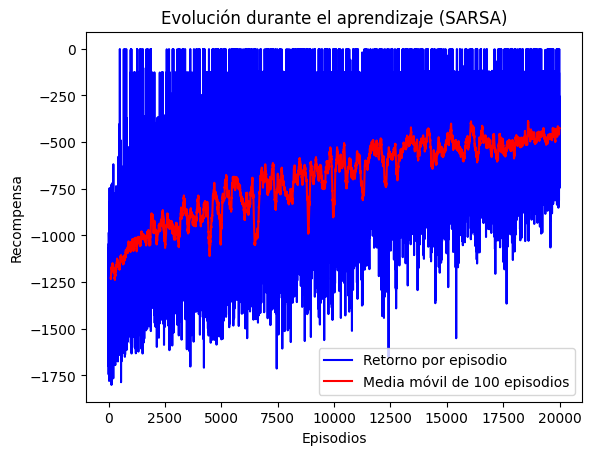

In [ ]:
q_valores_sarsa_p, retornos_sarsa_p = SARSA_o_QLRN(mode="sarsa",
                                               num_episodios=episodios_sarsa,
                                               ALPHA=ALPHA_sarsa,
                                               GAMMA=GAMMA_sarsa,
                                               EPSILON=EPSILON_sarsa,
                                               animate=False,
                                               perturbaciones=True)

medias_sarsa_p = plot_retornos(retornos_sarsa_p, "SARSA", rango_medias)

Episodio 100 | Retorno: -1367.173 | Pasos: 200 | avg R en los últimos 100 eps.: -1249.054
Episodio 200 | Retorno: -853.430 | Pasos: 200 | avg R en los últimos 100 eps.: -1224.949
Episodio 300 | Retorno: -907.442 | Pasos: 200 | avg R en los últimos 100 eps.: -1166.057
Episodio 400 | Retorno: -885.797 | Pasos: 200 | avg R en los últimos 100 eps.: -1180.200
Episodio 500 | Retorno: -1625.676 | Pasos: 200 | avg R en los últimos 100 eps.: -1119.480
Episodio 600 | Retorno: -988.252 | Pasos: 200 | avg R en los últimos 100 eps.: -1102.136
Episodio 700 | Retorno: -968.883 | Pasos: 200 | avg R en los últimos 100 eps.: -1141.042
Episodio 800 | Retorno: -1201.881 | Pasos: 200 | avg R en los últimos 100 eps.: -1141.167
Episodio 900 | Retorno: -1432.940 | Pasos: 200 | avg R en los últimos 100 eps.: -1070.185
Episodio 1000 | Retorno: -912.958 | Pasos: 200 | avg R en los últimos 100 eps.: -1085.752
Episodio 1100 | Retorno: -1441.828 | Pasos: 200 | avg R en los últimos 100 eps.: -1102.868
Episodio 1200 

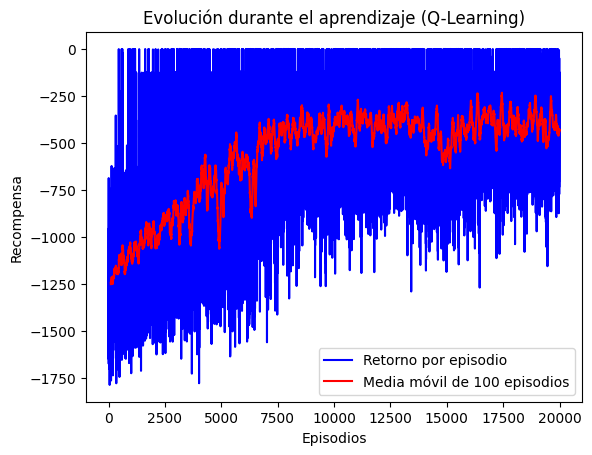

In [83]:
q_valores_q_learning_p, retornos_q_learning_p = SARSA_o_QLRN(mode="q_learning",
                                                         num_episodios=episodios_q_learning,
                                                         ALPHA=ALPHA_q_learning,
                                                         GAMMA=GAMMA_q_learning,
                                                         EPSILON=EPSILON_q_learning,
                                                         animate=False,
                                                         perturbaciones=True)

medias_q_learning_p = plot_retornos(retornos_q_learning_p, "Q-Learning", rango_medias)

### Evaluación

#### Políticas deterministas (con perturbaciones)

In [84]:
politica_sarsa_p = crea_politica_avara(q_valores_sarsa_p)
politica_q_learning_p = crea_politica_avara(q_valores_q_learning_p)

In [85]:
print(f"Montecarlo (aprendizaje durante {episodios_montecarlo} episodios, gamma={GAMMA_montecarlo}, epsilon={EPSILON_montecarlo})")
r_media_mc_p, std_mc_p = evaluate_method(politica_montecarlo_p, env2, estados_iniciales=iniciales, perturbaciones=True)

print(f"SARSA (aprendizaje durante {episodios_sarsa} episodios, alpha={ALPHA_sarsa}, gamma={GAMMA_sarsa}, epsilon={EPSILON_sarsa})")
r_media_sarsa_p, std_sarsa_p = evaluate_method(politica_sarsa_p, env2, estados_iniciales=iniciales, perturbaciones=True)

print(f"Q-Learning (aprendizaje durante {episodios_q_learning} episodios, alpha={ALPHA_q_learning}, gamma={GAMMA_q_learning}, epsilon={EPSILON_q_learning})")
r_media_q_learning_p, std_q_learning_p = evaluate_method(politica_q_learning_p, env2, estados_iniciales=iniciales, perturbaciones=True)

Montecarlo (aprendizaje durante 20000 episodios, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -265.004 con una política puramente greedy

SARSA (aprendizaje durante 20000 episodios, alpha=0.15, gamma=0.99, epsilon=0.15)
En 1000 episodios:
Este método consigue una recompensa media de -244.693 con una política puramente greedy

Q-Learning (aprendizaje durante 20000 episodios, alpha=0.1, gamma=0.99, epsilon=0.1)
En 1000 episodios:
Este método consigue una recompensa media de -344.875 con una política puramente greedy



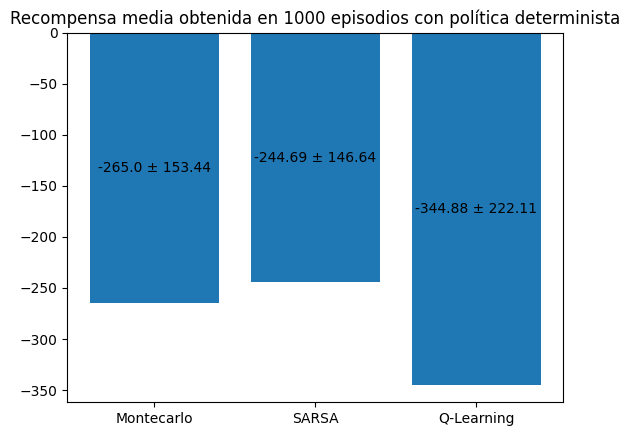

In [86]:
bar_p = plt.bar(["Montecarlo",
                "SARSA",
                "Q-Learning"],
                [r_media_mc_p, r_media_sarsa_p, r_media_q_learning_p])

labels_p = [f"{r_media_mc_p} ± {std_mc_p}",
          f"{r_media_sarsa_p} ± {std_sarsa_p}",
          f"{r_media_q_learning_p} ± {std_q_learning_p}"]

plt.bar_label(bar_p, labels_p, label_type="center")
plt.title(f"Recompensa media obtenida en {episodios_test} episodios con política determinista")
plt.show()

#### Algoritmos de control

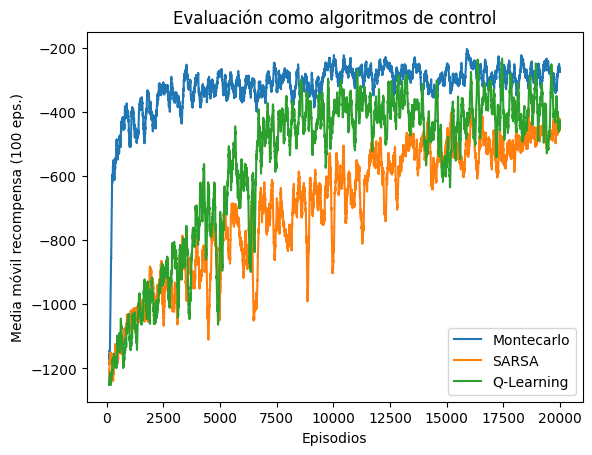

In [87]:
plot_varios_retornos([(medias_montecarlo_p, "Montecarlo"),
                      (medias_sarsa_p, "SARSA"),
                      (medias_q_learning_p, "Q-Learning")],
                        rango_medias)